## Code to validate the rate of convergence for the derived algorithm

### Import package

In [11]:
import numpy as np
from networkx import *
import matplotlib.pyplot as plt
from topology import *
%config InlineBackend.figure_format = 'svg'

### Network topology

In [12]:
def generate_graph(K,method,pro):
    '''
    Generate connected network
    ''' 
    degree = np.zeros((K,K)) # degree matrix 
    adjacency = np.zeros((K,K)) # adjacency matrix 
    eigenvalue = 0
    while eigenvalue < 1e-4:
        A  =  generate_network(K, method, plot= False, prob = pro)
        adjacency[A[0]>0] = 1
        for k in range(K):
            adjacency[k,k] = 0
            degree[k,k] = sum(adjacency[k])
        Laplacian = degree - adjacency
        W,D,h = np.linalg.svd(Laplacian)
        eigenvalue = D[-2]
        print("eigenvalue of Laplacian is:", eigenvalue)
    return A

In [19]:
def compute_perron(A, K):
    perron = np.random.rand(K, 1)
    perron = perron/np.sum(perron)
    for i in range(1000):
        perron = A.dot(perron)
        if np.linalg.norm(A.dot(perron) - perron) < 1e-8:
            print(f'Perron eigenvector is found within iterations {i}')
            return perron
    print(perron)
    return perron

In [98]:
method = 'average_rule'   # left-stochastic matrix
K = 8                    # number of nodes
prob = 0.6                # link probability
A = generate_graph(K, method, prob)  # generate topology

print(A[0])

eigenvalue of Laplacian is: 1.3983208681168453
[[0.25       0.         0.2        0.         0.         0.125
  0.25       0.        ]
 [0.         0.16666667 0.2        0.25       0.2        0.125
  0.         0.25      ]
 [0.25       0.16666667 0.2        0.         0.         0.125
  0.25       0.        ]
 [0.         0.16666667 0.         0.25       0.2        0.125
  0.         0.        ]
 [0.         0.16666667 0.         0.25       0.2        0.125
  0.         0.25      ]
 [0.25       0.16666667 0.2        0.25       0.2        0.125
  0.25       0.25      ]
 [0.25       0.         0.2        0.         0.         0.125
  0.25       0.        ]
 [0.         0.16666667 0.         0.         0.2        0.125
  0.         0.25      ]]


### Algorithm setting

In [102]:
M = 20 # feature dimension 
Bs = 1 # batch size 
var = 1e-4
mean = np.zeros(M)      # mean vector of multi-dimensional Gaussian
cov  = var * np.eye(M)  # covariance matrix of multi-dimensional Gaussian
mu_As = 0               # mean of 1-D Gaussian
sigma_As = var    

### Data generation

In [33]:
def batch_data(M, B, K):
    '''
    Arguments:
    
    M: feature dimension
    B: batch size 
    K: number of agents
    
    Return:
    
    As: sample mean for matrix As
    gx: sample mean asscoiated with variable x
    gy: sample mean asscoiated with variable y
    '''
    As = np.zeros((K*M, M))  # [I_M; I_M; I_M; ...]
    gx = np.zeros((K*M, 1))    #  [gx_1; gx_2; ....]
    gy = np.zeros((K*M, 1))    #  [gy_1; gy_2; ....]

    for b in range(B):
        for k in range(K):
            As[k*M:(k+1)*M, :] = As[k*M:(k+1)*M, :] + np.random.normal(mu_As, sigma_As, size=(M,M))
            if M >1:
                gx[k*M:(k+1)*M, :] = gx[k*M:(k+1)*M, :] + np.random.multivariate_normal(mean, cov, 1).transpose()
                gy[k*M:(k+1)*M, :] = gy[k*M:(k+1)*M, :] + np.random.multivariate_normal(mean, cov, 1).transpose()
            else:
                gx[k*M:(k+1)*M, :] = gx[k*M:(k+1)*M, :] + np.random.normal(mean, cov)
                gy[k*M:(k+1)*M, :] = gy[k*M:(k+1)*M, :] + np.random.normal(mean, cov)

    As = As/B + np.kron(np.ones((K, 1)), np.eye(M))  # random matrix
    gx = gx/B   
    gy = gy/B    

    return As, gx, gy  

### Train algorithm

- Gradient computation

In [20]:
def compute_loss_gradient(y_kron, x_kron, As, gys, gxs, K, M):
    '''
    Arguments:
    
    Compute loss gradient
    
    y_kron: network model w.r.t y
    x_kron: network model w.r.t x
    As: batch mean for the sample matrix 
    gys: batch mean for the sample vector
    gxs: batch mean for the sample vector
    K: number of nodes 
    M: feature dimension
    '''

    grad_x = np.zeros((M * K, 1))   # stochastic gradient w.r.t to x
    grad_y = np.zeros((M * K, 1))   # stochastic gradient w.r.t to y

    for k in range(K):
        # Perform matrix multiplication 
        grad_x[k*M:(k+1)*M, 0] = As[k*M:(k+1)*M, :].dot(y_kron[k*M:(k+1)*M, 0]) + gxs[k*M:(k+1)*M, 0]
        grad_y[k*M:(k+1)*M, 0] = As[k*M:(k+1)*M, :].transpose().dot(x_kron[k*M:(k+1)*M, 0]) + gys[k*M:(k+1)*M, 0]
        
    return grad_x, grad_y

In [145]:
N = 2000    # number of iterations
NN = 1      # number of trials
lam = 0.1   # regularization terms


scale = np.array([0.001, 0.01, 0.1, 0.2, 0.4])
scale_step = np.array([0.001, 0.01, 0.1, 0.2, 0.4])*np.sqrt(N)

group = len(scale_step)

print(scale_step.shape)
mux = scale_step/np.sqrt(N)
print(mux)
muy = 5*mux


perron = compute_perron(A[0], K)

A_kron = np.kron(A[0].transpose(), np.eye(M))  # Combination matrix in Kronecker product form
p_kron = np.kron(perron, np.eye(M)) 

P_grad = np.zeros((group, NN, N))

for g in range(group):
    
    for trial in range(NN):

        # Initialize the buffer for the network model  [old_network_model, new_network_model]
        x_kron =  np.kron(np.ones((1, 2)),5 * np.random.randn(M*K,1)) 
        y_kron =  np.kron(np.ones((1, 2)),5 * np.random.randn(M*K,1))

        for ite in range(N):


            # get a batch of sample
            As, gxs, gys = batch_data(M, Bs, K)

            # using data samples to compute the gradient at point (x_{k, i-1}, y_{k, i-1}) and point (x_{k ,i-2}, y_{k ,i-2}) respectively
            grad_x_new, grad_y_new  = compute_loss_gradient(y_kron[:, [1]], x_kron[:, [1]], As, gys, gxs, K, M) 
            grad_x_old, grad_y_old  = compute_loss_gradient(y_kron[:, [0]], x_kron[:, [0]], As, gys, gxs, K, M)

            # adaptation
            phix_kron = x_kron[:, [1]] - mux[g] * (2*grad_x_new - grad_x_old)
            phiy_kron = y_kron[:, [1]] + muy[g] * (2*(grad_y_new - 2*lam* y_kron[:, [1]]) - (grad_y_old - 2*lam*y_kron[:, [0]]))



            # combination
            x_kron_com = A_kron.dot(phix_kron)
            y_kron_com = A_kron.dot(phix_kron)

            # shift memory
            x_kron[:, [0]] = x_kron[:, [1]]
            y_kron[:, [0]] = y_kron[:, [1]]

            x_kron[:, [1]] = x_kron_com
            y_kron[:, [1]] = y_kron_com

            P_temp = np.zeros((M, 1))
            
            # y^o(x_{c, i}) = argmax_y J(x_{c,i}, y) = \frac{1}{2*\lambda} \sum_{k=1}^{K} p_k x_{c, i} =x_{c, i}/(2*\lambda)
            
            # \nabla P(x_{c, i}) = \nabla_x J(x_{c, i}, y^o(x_{c, i})) = \sum_{k=1}^{K} p_k y^o(x_{c, i}) = y^o(x_{c, i})
            
            # compute the primal gradient x_{c, i}/(2*\lambda)
            
            for  k in range(K):
                P_temp += perron[k]*x_kron[k*M:(k+1)*M, [1]]/(2*lam)
           
            
            P_grad[g, trial, ite] = np.linalg.norm(P_temp)    

            if ite%1000 == 0:                                  
                print(f'Number of trial {trial}, iteration number {ite}')

P_plot = np.zeros((group, N))
for g in range(group):
    P_temp = P_grad[g, :, :] 
    P_plot[g, :] = np.mean(P_temp, axis=0)

print(P_plot.shape)
print('Simulation finish!')

(5,)
[0.001 0.01  0.1   0.2   0.4  ]
Perron eigenvector is found within iterations 37
Number of trial 0, iteration number 0
Number of trial 0, iteration number 1000
Number of trial 0, iteration number 0
Number of trial 0, iteration number 1000
Number of trial 0, iteration number 0
Number of trial 0, iteration number 1000
Number of trial 0, iteration number 0
Number of trial 0, iteration number 1000
Number of trial 0, iteration number 0
Number of trial 0, iteration number 1000
(5, 2000)
Simulation finish!


### Plot simulation result

0.001
0.01
0.1
0.2
0.4


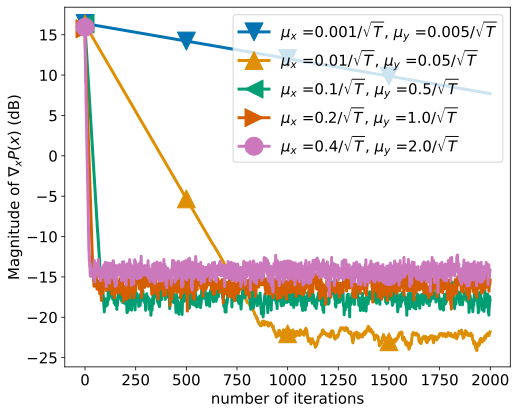

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

%config InlineBackend.figure_format = 'svg'

markers = ["v","^","<",">","o","s","p","P","*"]
colors = sns.color_palette('colorblind')


plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (8, 6.5)
legend_labels = []

names = []
for g in range(group):
    mux = scale[g]
    print(mux)
    muy = 5*scale[g]
    name = r"$\mu_x$ ="+str(mux)+r"/$\sqrt{T}$, $\mu_y$ ="+str(muy)+ r"/$\sqrt{T}$"
    names.append(name)

for g in range(group):
    cc = colors[g%10]
    ls='-'
    plt.plot(range(N), 10*np.log10(P_plot[g,:]), linestyle=ls, marker = markers[g%10], linewidth=3,color =  cc, markevery=500, markersize = 18)
    
plt.legend(names, loc='upper right')
plt.xlabel('number of iterations')
plt.ylabel(r'Magnitude of $\nabla_x P(x)$ (dB)')
plt.savefig('rate_validation.jpg')